In [1]:
import numpy as np
import pandas as pd
import os
from sklearn.metrics import *
import random
import matplotlib.pyplot as plt


In [2]:
import os
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error

# 설정
data = ['coin']
model_name = 'trTFMLP'
num = 100  # Model k per loss
np.random.seed(100)

bolt_all_data = []
performance_lst = []

for d in range(len(data)):
    # 데이터 로드
    target_X = pd.read_csv(f"../data/{data[d]}/train_input_7.csv").iloc[:,1:].values.astype(np.float32)
    target_y = pd.read_csv(f"../data/{data[d]}/train_output_7.csv").iloc[:,1:].values.astype(np.float32)
    
    target_X_val = target_X[-round(target_X.shape[0]*0.2):,:]
    target_y_val = target_y[-round(target_y.shape[0]*0.2):]
    target_X = target_X[:-round(target_X.shape[0]*0.2),:]
    target_y = target_y[:-round(target_y.shape[0]*0.2)]

    test_X = pd.read_csv(f"../data/{data[d]}/val_input_7.csv").iloc[:,1:].values.astype(np.float32)
    test_y = pd.read_csv(f"../data/{data[d]}/val_output_7.csv").iloc[:,1:].values.astype(np.float32)

    # 결과 파일 불러오기
    folder_path = 'result/test/'
    folder_path2 = 'result/val/'
    all_files = os.listdir(folder_path)
    all_files2 = os.listdir(folder_path2)
    
    files = sorted([f for f in all_files if f.startswith(f"{model_name}_{data[d]}") and f.endswith("pred.csv")])
    files2 = sorted([f for f in all_files2 if f.startswith(f"{model_name}_{data[d]}") and f.endswith("pred.csv")])
    dataframes = [pd.read_csv(os.path.join(folder_path, f)) for f in files]
    dataframes2 = [pd.read_csv(os.path.join(folder_path2, f)) for f in files2]

    all = np.array([np.stack(df.iloc[:,1:].values.reshape(num,-1,target_y.shape[1])) for df in dataframes])
    all_val = np.array([np.stack(df.iloc[:,1:].values.reshape(num,-1,target_y.shape[1])) for df in dataframes2])

    # 평가 루프
    p = 10
    b = 30
    all_ens_mae_lst = []
    bolt_mae_lst = []
    inv_mae_lst = []
    mean_mae_lst = []
    
# ============================ ▼▼▼ 추가할 코드 ▼▼▼ ============================
    # 1. 상세 분석을 위한 변수 초기화
    os.makedirs('inference', exist_ok=True)  # 저장 폴더 생성
    samples = []  # 각 반복에서 샘플링된 모델 인덱스 저장용
    best_beta_rows = [] # 반복별 최적 beta 정보 저장용
    
    # beta 값에 따른 가중치 변화를 기록하기 위한 딕셔너리
    beta_grid = np.arange(0.05, 10.05, 0.05)
    weights_by_beta = {float(np.round(b, 3)): [] for b in beta_grid}
# ============================ ▲▲▲ 추가할 코드 ▲▲▲ ============================
    
    for i in range(b):
        nums = [np.random.choice(num, size=p, replace=False) for _ in range(5)]

        score = np.concatenate([all[j][nums[j]] for j in range(5)], axis=0)
        all_ens = np.median(score, axis=0).flatten()
        all_ens_mae = mean_absolute_error(test_y.flatten(), all_ens)
        all_ens_mae_lst.append(all_ens_mae)

# ============================ ▼▼▼ 상세 Breakdown 생성 코드 (MAE 기준) ▼▼▼ ============================
        # 첫 번째 부트스트랩 반복(i=0)에 대해서만 상세 분석 파일 생성
        if i == 0:
            y_true_flat = test_y.flatten()
            num_timesteps = all_ens.shape[0]

            # --- 1. Median 앙상블 Breakdown (MAE 포함) ---
            median_breakdown_rows = []
            num_models = score.shape[0]
            for t in range(num_timesteps):
                row = {
                    'iter': i, 't': t, 'y_true': y_true_flat[t],
                    'median_pred': all_ens[t],
                    'mae': np.abs(y_true_flat[t] - all_ens[t]) # 시점별 MAE 추가
                }
                source_preds = score[:, t // target_y.shape[1], t % target_y.shape[1]].flatten()
                for m in range(num_models):
                    row[f'pred_model_{m+1}'] = source_preds[m]
                median_breakdown_rows.append(row)

            df_median = pd.DataFrame(median_breakdown_rows)
            df_median.to_csv(f'inference/{model_name}_{data[d]}_median_breakdown_mae.csv', index=False)
            print(f"INFO: Median breakdown for iter 0 saved.")

            # --- 2. 특정 Beta(1, 3, 5) 값에 대한 BOLT 앙상블 Breakdown ---
            target_betas = [1, 3, 5]
            loss_names = ['mae', 'mape', 'mase', 'mse', 'smape']

            for target_beta in target_betas:
                # (1) 해당 beta로 가중치 및 앙상블 예측 다시 계산
                weights = np.exp(-target_beta * performance)
                weights /= np.sum(weights)
                # gd 변수가 루프 뒷부분에 있으므로 여기서 생성
                gd = np.stack(fin_preds, axis=0)
                ensemble_prediction = np.dot(weights, gd)

                # (2) Breakdown 데이터 생성
                bolt_breakdown_rows = []
                for t in range(num_timesteps):
                    row = {
                        'iter': i, 'beta': target_beta, 't': t, 'y_true': y_true_flat[t],
                        'ensemble_pred': ensemble_prediction[t],
                        'mae': np.abs(y_true_flat[t] - ensemble_prediction[t]) # 시점별 MAE 추가
                    }
                    # 5개 손실 그룹의 기본 예측값과 가중치 추가
                    base_preds_t = gd[:, t]
                    for loss_idx, name in enumerate(loss_names):
                        row[f'base_pred_{name}'] = base_preds_t[loss_idx]
                        row[f'w_{name}'] = weights[loss_idx]
                    bolt_breakdown_rows.append(row)

                # (3) 파일로 저장
                df_bolt = pd.DataFrame(bolt_breakdown_rows)
                dbg_path = f'inference/{model_name}_{data[d]}_bolt_breakdown_beta_{target_beta}_mae.csv'
                df_bolt.to_csv(dbg_path, index=False)
                print(f"INFO: BOLT breakdown for beta={target_beta} saved.")

# ============================ ▲▲▲ 상세 Breakdown 생성 코드 (MAE 기준) ▲▲▲ ============================
        
        mean_mae = np.mean(score, axis=0).flatten()
        all_mean_mae = mean_absolute_error(test_y.flatten(), mean_mae)
        mean_mae_lst.append(all_mean_mae)

        # 각 지표별 예측
        val_preds = [np.median(np.nan_to_num(all_val[j][nums[j]], nan=0), axis=0).flatten() for j in range(5)]
        perf_maes = [mean_absolute_error(target_y_val.flatten(), pred) for pred in val_preds]

        fin_preds = [np.median(np.nan_to_num(all[j][nums[j]], nan=0), axis=0).flatten() for j in range(5)]
        performance = np.array(perf_maes)
        performance_lst.append(performance)

        bolt = []
        bolt_mae_lst_ = []
# ============================ ▼▼▼ 추가/수정할 코드 (1/2) ▼▼▼ ============================
        weights_seq = [] # 현재 반복(iter)의 beta별 가중치를 순서대로 저장
        samples.append(nums) # 현재 반복에서 샘플링한 모델 인덱스 저장
# ============================ ▲▲▲ 추가/수정할 코드 (1/2) ▲▲▲ ============================
        for beta in np.arange(0.05, 10.05, 0.05):
            weights = np.exp(-beta * performance)
            normalized_weights = weights / np.sum(weights)
# ============================ ▼▼▼ 추가/수정할 코드 (2/2) ▼▼▼ ============================
            # beta 값 별 가중치 변화 기록
            weights_by_beta[float(np.round(beta, 3))].append(normalized_weights.copy())
            weights_seq.append(normalized_weights.copy())
# ============================ ▲▲▲ 추가/수정할 코드 (2/2) ▲▲▲ ============================
            gd = np.stack(fin_preds, axis=0)
            ensemble_prediction = np.dot(normalized_weights, gd)
            bolt.append(ensemble_prediction)
            bolt_mae = mean_absolute_error(test_y.flatten(), ensemble_prediction.flatten())
            bolt_mae_lst_.append(bolt_mae)
        bolt_mae_lst.append(bolt_mae_lst_)
# ============================ ▼▼▼ 추가할 코드 ▼▼▼ ============================
        # 현재 반복(iter)에서 최적의 beta와 그때의 가중치/성능 기록
        best_idx = np.argmin(bolt_mae_lst_)
        best_beta_rows.append({
            'iter': i,
            'beta': float(np.round(beta_grid[best_idx], 3)),
            'bolt_mae': bolt_mae_lst_[best_idx],
            'w_mae':   weights_seq[best_idx][0],
            'w_mape':  weights_seq[best_idx][1],
            'w_mase':  weights_seq[best_idx][2],
            'w_mse':   weights_seq[best_idx][3],
            'w_smape': weights_seq[best_idx][4],
        })
# ============================ ▲▲▲ 추가할 코드 ▲▲▲ ============================
        inv_weights = 1.0 / performance
        inv_weights /= np.sum(inv_weights)
        ens_pred_inv = np.dot(inv_weights, gd)
        inv_mae = mean_absolute_error(test_y.flatten(), ens_pred_inv.flatten())
        inv_mae_lst.append(inv_mae)

    bolt_all_data.append(bolt_mae_lst)
    a = np.min(np.array(bolt_mae_lst), axis=0)
    summary = pd.DataFrame({
        'BOLT': np.min(np.array(bolt_mae_lst), axis=1),
        'Median': all_ens_mae_lst,
        'INV': inv_mae_lst,
        'Mean': mean_mae_lst
    })
# ============================ ▼▼▼ 추가할 코드 ▼▼▼ ============================
    # 4. 수집된 상세 분석 로그 파일로 저장
    # (1) 반복(iter)별 최적 beta 정보 저장
    pd.DataFrame(best_beta_rows).to_csv(f'inference/{model_name}_{data[d]}_best_beta_per_iter_mae.csv', index=False)
    
    # (2) Beta 값에 따른 가중치 변화 요약 저장
    rows = []
    for beta_val, Wlist in weights_by_beta.items():
        for it, w in enumerate(Wlist):
            rows.append({'beta': beta_val, 'iter': it, 'w_mae': w[0], 'w_mape': w[1], 'w_mase': w[2], 'w_mse': w[3], 'w_smape': w[4]})
    df_weights_raw = pd.DataFrame(rows)
    df_weights_summary = df_weights_raw.groupby('beta')[['w_mae','w_mape','w_mase','w_mse','w_smape']].agg(['mean','std']).round(6)
    df_weights_summary.to_csv(f'inference/{model_name}_{data[d]}_weights_summary_mae.csv')
    
    print(f"INFO: Detailed logs saved to 'inference/' folder.")
# ============================ ▲▲▲ 추가할 코드 ▲▲▲ ============================
    summary.to_csv(f'{model_name}_{data[d]}_summary_mae.csv')
    print(f'{data[d]} 완료')



INFO: Median breakdown for iter 0 saved.
INFO: Detailed logs saved to 'inference/' folder.
coin 완료


In [3]:
rec = []
#data = ['TEM','SOL', 'WID', 'AIR', 'MET', 'COIN']
for i in range(len(data)):
    d= pd.read_csv(f'{model_name}_{data[i]}_summary_mae.csv').iloc[:,1:].describe().T.iloc[:,1:3].round(5)
    d['mean(std)'] = d.apply(
    lambda r: f"{r['mean']:.3f} ({r['std']:.3f})", axis=1)
    
    rec.append(d.loc[:,'mean(std)'])

dfff = pd.DataFrame(rec).T

dfff.columns = data
dfff.to_csv(f'{model_name}_result_ensemble_mae.csv')


dfff

,coin
BOLT,22.349 (2.044)
Median,30.902 (1.813)
INV,18.511 (1.212)
Mean,14.121 (1.067)


In [4]:
pd.DataFrame(np.array(performance_lst)).to_csv(f'perfomnace_val_{model_name}_mae.csv')

In [6]:
# ============================ ▼▼▼ 수정된 코드 ▼▼▼ ============================
# 5. 특정 Beta(1,3,5) 값에서의 평균 성능 확인
print("\n--- Performance at Specific Beta Values ---")
target_betas = [1, 3, 5]

# beta_grid를 생성할 때 사용한 np.arange의 부동소수점 오차를 피하기 위해 컬럼명을 반올림합니다.
beta_columns = [round(b, 2) for b in beta_grid]
bolt_results_df = pd.DataFrame(np.array(bolt_mae_lst), columns=beta_columns)

beta_perf_summary = []
for beta_val in target_betas:
    # .values를 추가하여 Index 객체를 NumPy 배열로 변환
    closest_beta_col = bolt_results_df.columns[np.abs(bolt_results_df.columns.values - beta_val).argmin()]
    
    mean_mae = bolt_results_df[closest_beta_col].mean()
    std_mae = bolt_results_df[closest_beta_col].std()
    
    beta_perf_summary.append({
        'target_beta': beta_val,
        'closest_beta': closest_beta_col,
        'mean_mae': mean_mae,
        'std_mae': std_mae
    })
    print(f"  Beta ≈ {closest_beta_col}: Mean MAE = {mean_mae:.5f} (std = {std_mae:.5f})")

df_beta_summary = pd.DataFrame(beta_perf_summary)
print("\nSpecific Beta Performance Summary:")
print(df_beta_summary)
# ============================ ▲▲▲ 수정된 코드 ▲▲▲ ============================


--- Performance at Specific Beta Values ---
  Beta ≈ 1.0: Mean MAE = 28.71822 (std = 4.97888)
  Beta ≈ 3.0: Mean MAE = 28.53104 (std = 4.87077)
  Beta ≈ 5.0: Mean MAE = 28.52044 (std = 4.85778)

Specific Beta Performance Summary:
   target_beta  closest_beta   mean_mae   std_mae
0            1           1.0  28.718222  4.978881
1            3           3.0  28.531040  4.870774
2            5           5.0  28.520444  4.857777


In [7]:
n1  = [1,3,5]
b135 = [] 
for j in range(1):
    a = np.array([np.array(bolt_all_data)[j].mean(axis=0)[np.where(np.arange(0.05,10.05,0.05) == n1[i])] for i in range(3)])
    b135.append(a)

df135 = pd.DataFrame(np.array(b135).reshape(1,3)).T
df135.columns = data
df135.T.round(3)

,0,1,2
coin,28.718,28.531,28.52


In [8]:
from scipy.stats import anderson

result = anderson(residuals, dist='norm')
print("Anderson-Darling test statistic:", result.statistic)
for cv, sig in zip(result.critical_values, result.significance_level):
    print(f"Significance level {sig}%: critical value = {cv}")

NameError: name 'residuals' is not defined

(array([   6.,   10.,    4.,   10.,   26.,   72.,  131.,  219.,  341.,
         795., 1627., 2182., 1774.,  885.,  350.,  107.,   32.,   12.,
           6.,    3.]),
 array([-16.90038611, -15.41528472, -13.93018334, -12.44508195,
        -10.95998056,  -9.47487918,  -7.98977779,  -6.5046764 ,
         -5.01957502,  -3.53447363,  -2.04937225,  -0.56427086,
          0.92083053,   2.40593191,   3.8910333 ,   5.37613469,
          6.86123607,   8.34633746,   9.83143885,  11.31654023,
         12.80164162]),
 <BarContainer object of 20 artists>)

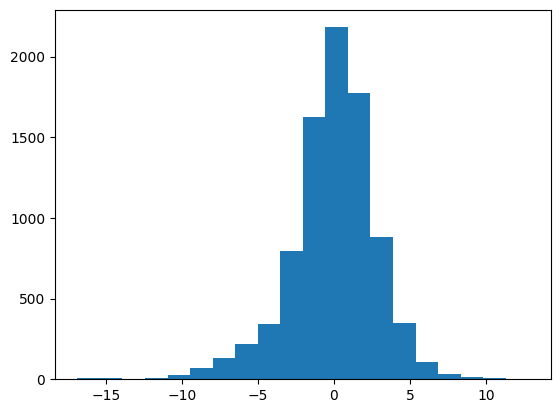

In [36]:
plt.hist(test_y.flatten() -(all[0][0]).flatten(), bins =20) #.shape